# Pipeline for High-z Radio Galaxies 18: Redshift prediction

## Introduction

Training for regression (prediction) of redshift for sources in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue. But regression  
will be done with AGN from the Million Quasar Catalog (MQC) and QSO from SDSS DR16.  
Only sources with confirmed $z$ will be used.

Being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import mpl_scatter_density
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
# from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
import cmasher as cmr
# from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Define specific metrics for redshift values:  

$$
\sigma_{\mathrm{NMAD}} = 1.48 \times \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

In [6]:
def sigma_mad(z_true, z_pred, **kwargs):
    med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    return 1.48 * med

In [7]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    med  = np.nanmedian(np.abs(frac)).astype('float32')
    return 1.48 * med

In [8]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [9]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [10]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    siz  = np.sum(np.isfinite(dif)).astype('float32')
    num  = np.sum(np.array(dif > 0.15)).astype('float32')
    frac = num / siz
    return frac

Methdods for PyCaret and saved models.

In [11]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [12]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [13]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

In [14]:
def get_base_estimators_names(pycaret_pipeline):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        estimators  = pycaret_pipeline['trained_model'].estimators
    else:
        estimators  = pycaret_pipeline.estimators

    estimators_list = [estimator[0] for estimator in estimators]
    return estimators_list

Methods to create values of metrics by redshift ranges

In [15]:
def z_metric_in_z_ranges(data_set_df, z_col, z_range, metric_function, *metricArgs):
    metric_output  = np.zeros_like(z_range)
    true_vals      = metricArgs[0]
    predicted_vals = metricArgs[1]
    for count, z_thresh in enumerate(z_range):
        filter_z             = data_set_df.loc[:, z_col] >= z_thresh
        if np.sum(filter_z) == 0:
            metric_output[count] = np.nan
            continue
        sub_set              = data_set_df.loc[filter_z, [*metricArgs]]
        metric_output[count] = metric_function(sub_set.loc[:, true_vals], sub_set.loc[:, predicted_vals])
    return metric_output

Method to plot metrics

In [16]:
def plot_metric_over_z(z_range, metric_range, name_metric, ax_pre, title=None, color=plt.get_cmap('cmr.redshift')(0.8)):
    ax_pre.plot(z_range, metric_range, color=color, zorder=10, alpha=0.93, marker='o', ls='-', lw=2.5)
    ##
    ax_pre.set_xlabel('$z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel(f'$\mathrm{{{name_metric}}} (\geq z)$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='major', labelsize=16)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_title(title, fontsize=14)
    ax_pre.grid(visible=True, alpha=0.1, zorder=0)
    plt.tight_layout()

***

## Reading data

In [17]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [18]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True

In [19]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [20]:
mqc_version = '7_4d'  # '7_2'

In [21]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [22]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [23]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [24]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

In [25]:
# full_catalog_df.describe()

#### Select only confirmed radio AGN

In [26]:
# full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]
filter_confirmed = full_catalog_df.loc[:, 'is_AGN'] == 1
filter_redshift  = (full_catalog_df.loc[:, 'Z'] > 0) | (full_catalog_df.loc[:, 'zsp'] > 0)
filter_radio     = full_catalog_df.loc[:, 'radio_detect'] == 1
full_catalog_df  = full_catalog_df.loc[filter_confirmed & filter_redshift & filter_radio]

In [27]:
n_full   = len(full_catalog_df)
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'radio_detect'] == 1)
print(f'In this dataset, with {n_full:,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, {n_is_gal:,} have been indentified as galaxies,' +\
      f' and {n_is_rad:,} are identified as radio detections.')

In this dataset, with 9,225 elements,
9,225 of them are marked as AGN, 0 have been indentified as galaxies, and 9,225 are identified as radio detections.


---

Combine redshift values (AGN + galaxies).

In [28]:
idx_non_Z                = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

## Possible correlations

In [29]:
print(full_catalog_df.columns.to_list())

['Z', 'zsp', 'band_num', 'radio_detect', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K', 'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2']


---

## Random seed

In [30]:
seed = 42

Create target

$0$ for galaxies and $1$ for AGN

In [31]:
# full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [32]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'radio_detect', 'zsp'])

---

#### Add prediction from first AGN/galaxy model as feature.

In [33]:
# AGN_gal_clf = pyc.load_model('models/classification_AGN_galaxy_apr_20_2022')

In [34]:
# AGN_pred_threshold = 0.5
# full_catalog_df    = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=AGN_pred_threshold, raw_score=False).drop(columns=['Score'])

In [35]:
# full_catalog_df = full_catalog_df.rename(columns={'Label': 'class'})

---

## Split data: Test, Train, Validation

In [36]:
# train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2,\
#                                                 random_state=seed, stratify=None)
train_test_df = full_catalog_df.loc[np.isfinite(full_catalog_df.loc[:, 'Z'])].sample(frac=0.8, random_state=seed)  # Train + test sets
validation_df = full_catalog_df.drop(train_test_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (9225, 39)
Data for Modeling (Train and Test): (7380, 39)
Unseen Data For Validation: (1845, 39)
----------------------------------------


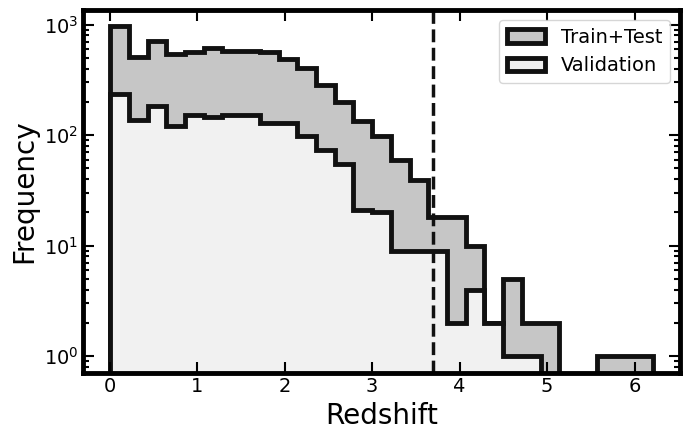

In [37]:
fig             = plt.figure(figsize=(7,4.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(train_test_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Train+Test')
ax1.hist(validation_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='Validation')

ax1.axvline(x=3.7, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Save indices of sources in validation sub-set for future steps.

In [38]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [39]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [40]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [41]:
rsd_vals

z_y         297.343074
i_z         250.880482
w1_w2       142.210299
r_i         137.169599
g_r         113.966837
g_i          95.246714
Z            68.283304
w2_w3        39.914257
J_H          33.895345
H_K          33.524109
w3_w4        25.996635
band_num     17.784968
W1mproPM      7.071574
W2mproPM      6.745856
gmag          6.732366
ymag          6.631762
rmag          6.617645
imag          6.574679
zmag          6.462214
w1/w4         5.811414
g/J           5.784473
i/K           5.595640
w2/w4         5.446554
r/H           5.428317
W3mag         4.799001
w1/w3         4.327016
y/W2          4.048017
z/W1          3.899510
NUVmag        3.196411
W4mag         3.182329
Hmag          3.098002
Jmag          3.007040
FUV/K         2.543265
i/y           2.350318
r/z           2.300232
Kmag          2.266753
FUVmag        1.303657
J/K           1.081665
FUV_NUV     -67.193944
dtype: float64

In [42]:
correlation = norm_train_test_df.corr()

In [43]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [44]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [45]:
target_feat = 'Z'

In [46]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [47]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [48]:
list_drop_corr

['Jmag',
 'Kmag',
 'imag',
 'W2mproPM',
 'rmag',
 'zmag',
 'w2/w4',
 'FUV_NUV',
 'r/H',
 'J/K',
 'w1/w3',
 'g/J',
 'w1/w4',
 'i/K',
 'Hmag',
 'W4mag',
 'ymag',
 'W3mag',
 'g_i',
 'W1mproPM']

In [49]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [50]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [51]:
corr_discard = norm_train_test_discard.corr()

In [52]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

Z         Z           1.000000
NUVmag    FUVmag      0.688668
y/W2      z/W1        0.676564
z_y       i/y         0.663473
band_num  gmag        0.661596
r_i       r/z         0.624153
i_z       r/z         0.622622
gmag      w3_w4       0.600922
w3_w4     band_num    0.594458
w2_w3     gmag        0.570398
          band_num    0.559555
H_K       FUV/K       0.555625
gmag      NUVmag      0.543381
H_K       band_num    0.541774
Z         z/W1        0.522630
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

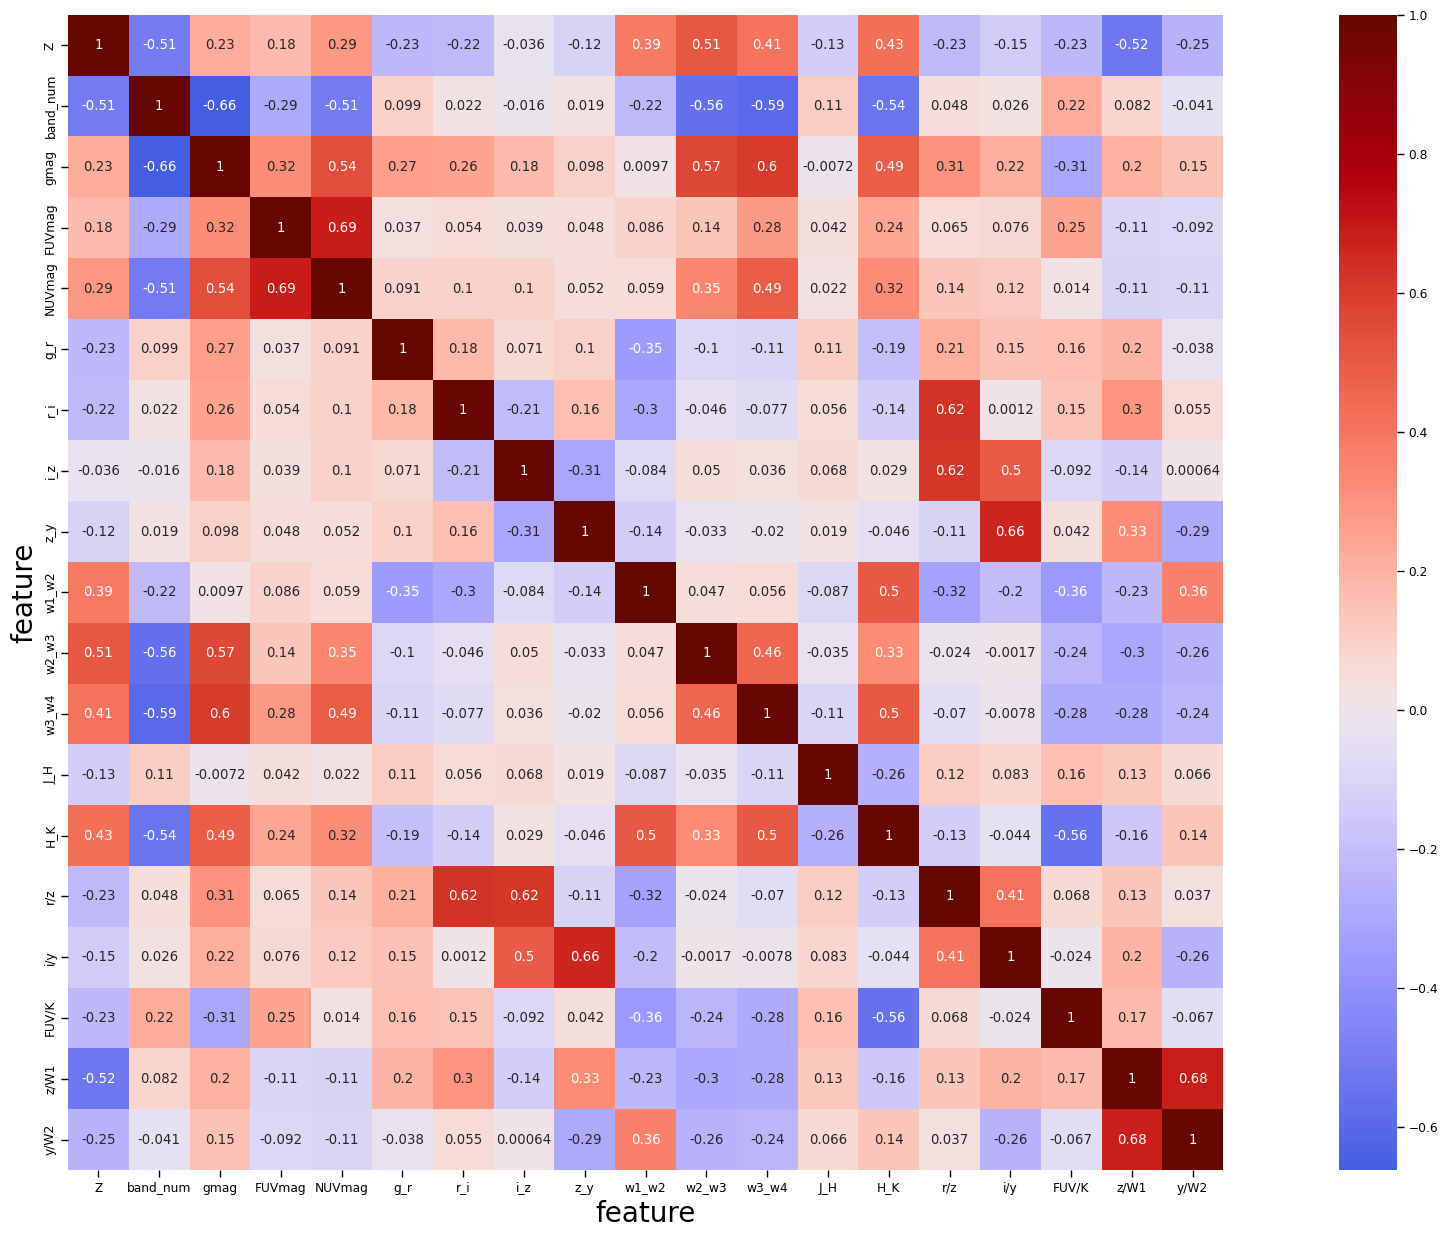

In [53]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [54]:
# norm_train_test_discard.loc[:, 'Z'] = norm_train_test_discard.loc[:, 'Z'].astype(bool)

In [55]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [56]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
FUV/K     FUV/K       1.000000
Z         H_K         0.408819
J_H       H_K         0.350826
NUVmag    FUVmag      0.341121
band_num  gmag        0.305503
J_H       band_num    0.279081
H_K       band_num    0.260805
FUV/K     H_K         0.244163
band_num  w3_w4       0.235046
          H_K         0.226083
          w2_w3       0.216893
          Z           0.215872
FUV/K     band_num    0.204351
NUVmag    band_num    0.185100
FUV/K     FUVmag      0.180697
band_num  NUVmag      0.166978
H_K       Z           0.159589
NUVmag    gmag        0.153278
J_H       Z           0.150063
FUV/K     Z           0.140079
dtype: float64

In [57]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [58]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [59]:
target_feat = 'Z'

In [60]:
list_drop_pps = []

In [61]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [62]:
list_drop_pps

[]

In [63]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [64]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'Z', random_seed=seed)

In [65]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,band_num,Z,0.215872,regression,True,mean absolute error,0.116813,0.091596,DecisionTreeRegressor()
1,H_K,Z,0.159589,regression,True,mean absolute error,0.116813,0.098170,DecisionTreeRegressor()
2,J_H,Z,0.150063,regression,True,mean absolute error,0.116813,0.099283,DecisionTreeRegressor()
3,FUV/K,Z,0.140079,regression,True,mean absolute error,0.116813,0.100450,DecisionTreeRegressor()
4,w1_w2,Z,0.026950,regression,True,mean absolute error,0.116813,0.113664,DecisionTreeRegressor()
5,FUVmag,Z,0.026639,regression,True,mean absolute error,0.116813,0.113701,DecisionTreeRegressor()
6,NUVmag,Z,0.015299,regression,True,mean absolute error,0.116813,0.115025,DecisionTreeRegressor()
7,w3_w4,Z,0.003775,regression,True,mean absolute error,0.116813,0.116372,DecisionTreeRegressor()
8,gmag,Z,0.000000,regression,True,mean absolute error,0.116813,0.147941,DecisionTreeRegressor()
9,g_r,Z,0.000000,regression,True,mean absolute error,0.116813,0.134762,DecisionTreeRegressor()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [63]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats.remove('J_H')  # After Boruta
final_feats.remove('FUVmag')  # After Boruta

In [64]:
feats_2_discard = list_drop_corr + list_drop_pps + ['J_H', 'FUVmag']

Boruta discards one feature.

In [65]:
exp_radio = pyr.setup(data=train_test_df, target='Z', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta',\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,Z
2,Original Data,"(7380, 39)"
3,Missing Values,False
4,Numeric Features,16
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(5165, 16)"


In [66]:
pyr.get_config('X').columns

Index(['band_num', 'gmag', 'NUVmag', 'g_r', 'r_i', 'i_z', 'z_y', 'w1_w2',
       'w2_w3', 'w3_w4', 'H_K', 'r/z', 'i/y', 'FUV/K', 'z/W1', 'y/W2'],
      dtype='object')

In [67]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Add custom metrics

In [68]:
pyr.add_metric('s_mad',  'sigma_mad',    sigma_mad,    greater_is_better=False)
pyr.add_metric('s_nmad', 'sigma_nmad',   sigma_nmad,   greater_is_better=False)
pyr.add_metric('s_z',    'sigma_z',      sigma_z,      greater_is_better=False)
pyr.add_metric('s_z_n',  'sigma_z_norm', sigma_z_norm, greater_is_better=False)
pyr.add_metric('out_f',  'outlier_fr',   outlier_frac, greater_is_better=False)

Name                                                        outlier_fr
Display Name                                                outlier_fr
Score Function               <function outlier_frac at 0x7f10fdc9ba60>
Scorer               make_scorer(outlier_frac, greater_is_better=Fa...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: out_f, dtype: object

In [69]:
final_selection_reg  = ['rf', 'et', 'dt', 'lightgbm', 'catboost', 'dummy']  # knn discarded: no feature importances
n_models             = 5
top_model_z          = pyr.compare_models(n_select=n_models, include=final_selection_reg, sort='s_mad')  # 1:15 hour for used_models_clf
# top_model_z          = pyr.compare_models(n_select=n_models, exclude=['knn'], sort='s_mad')  # 5 minutes, using all models.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr,TT (Sec)
rf,Random Forest Regressor,0.2755,0.2285,0.4765,0.7045,0.1998,0.5298,0.2071,0.0912,0.4765,0.2326,0.2436,0.5000
et,Extra Trees Regressor,0.2717,0.2115,0.4588,0.7264,0.1921,0.4953,0.2134,0.0972,0.4588,0.2212,0.2445,0.2090
lightgbm,Light Gradient Boosting Machine,0.2813,0.2124,0.4598,0.7253,0.1931,0.5473,0.2393,0.1111,0.4598,0.2180,0.2629,27.2780
catboost,CatBoost Regressor,0.2817,0.2118,0.4593,0.7258,0.1930,0.5786,0.2428,0.1133,0.4593,0.2205,0.2590,0.5740
dt,Decision Tree Regressor,0.3796,0.4581,0.6738,0.4054,0.2766,0.5916,0.2443,0.1106,0.6738,0.3495,0.3011,0.0170
dummy,Dummy Regressor,0.7326,0.7765,0.8809,-0.0011,0.4041,3.0092,1.0390,0.4197,0.8809,0.5027,0.7473,0.0080


Thus, we select `lightgbm` as meta learner.

Thus, we stack the models.

In [70]:
stacked_model_z = pyr.stack_models(estimator_list=top_model_z[1:], meta_model=top_model_z[0], optimize='s_mad')

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2540,0.1908,0.4368,0.7647,0.1885,0.4274,0.1796,0.0765,0.4368,0.2271,0.2012
1,0.2645,0.2240,0.4733,0.7050,0.1917,0.5204,0.1959,0.0866,0.4733,0.2061,0.2224
2,0.2699,0.2477,0.4977,0.6749,0.2071,0.4184,0.1898,0.0807,0.4977,0.2261,0.2186
3,0.2594,0.2053,0.4532,0.7599,0.1855,0.5348,0.1760,0.0800,0.4532,0.2259,0.2186
4,0.2628,0.1947,0.4413,0.7264,0.1998,0.5174,0.1909,0.0837,0.4413,0.2405,0.2418
5,0.2566,0.2232,0.4724,0.7327,0.1970,0.5641,0.1713,0.0785,0.4724,0.2418,0.2151
6,0.2587,0.2381,0.4880,0.6810,0.1988,0.5186,0.1699,0.0785,0.4880,0.2298,0.2229
7,0.2463,0.1930,0.4394,0.7443,0.1853,0.4352,0.1782,0.0844,0.4394,0.2262,0.2035
8,0.2299,0.1646,0.4057,0.7808,0.1674,0.4400,0.1747,0.0783,0.4057,0.1770,0.1957


In [71]:
tuned_z_reg = pyr.tune_model(stacked_model_z, early_stopping='asha', optimize='s_mad')#,\
#                                search_library='tune-sklearn', search_algorithm='random')  # 1h30

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2528,0.1904,0.4363,0.7653,0.1837,0.3648,0.1661,0.0764,0.4363,0.2088,0.2166
1,0.2705,0.2390,0.4889,0.6853,0.1904,0.3762,0.1882,0.0903,0.4889,0.1962,0.2244
2,0.2543,0.2265,0.4759,0.7028,0.1965,0.3970,0.1865,0.0821,0.4759,0.2006,0.2108
3,0.2574,0.1959,0.4426,0.7709,0.1779,0.4039,0.1795,0.0843,0.4426,0.2088,0.2224
4,0.2706,0.2039,0.4516,0.7134,0.2002,0.4733,0.2068,0.0911,0.4516,0.2345,0.2302
5,0.2556,0.2169,0.4658,0.7402,0.1909,0.6618,0.1768,0.0773,0.4658,0.2372,0.2132
6,0.2568,0.2335,0.4833,0.6871,0.1933,0.4370,0.1808,0.0845,0.4833,0.2081,0.2016
7,0.2504,0.1914,0.4375,0.7465,0.1838,0.4159,0.1940,0.0843,0.4375,0.2118,0.2132
8,0.2298,0.1519,0.3898,0.7977,0.1574,0.4226,0.1859,0.0795,0.3898,0.1583,0.1802


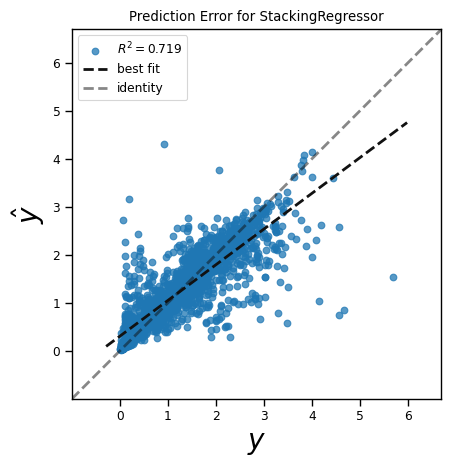

In [72]:
pyr.plot_model(tuned_z_reg, plot='error')

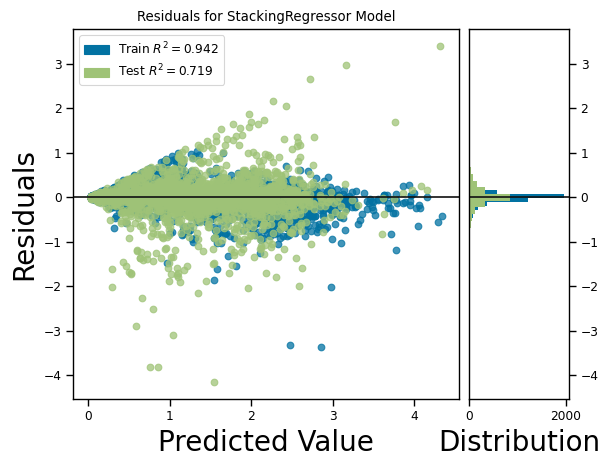

In [73]:
pyr.plot_model(tuned_z_reg, plot='residuals')

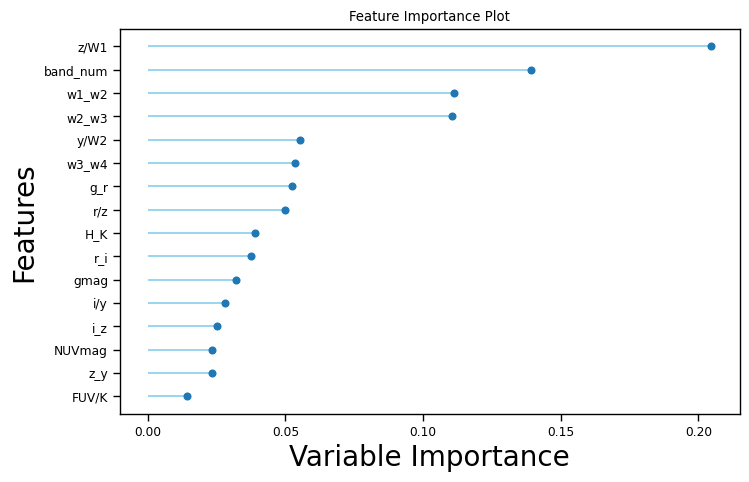

In [74]:
pyr.plot_model(tuned_z_reg.estimators_[0], plot='feature_all')

In [75]:
pyr.plot_model(tuned_z_reg.final_estimator, plot='parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
criterion,mae
max_depth,11
max_features,log2
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0001
min_impurity_split,None
min_samples_leaf,3


In [76]:
plt.rcParams.update(plt.rcParamsDefault)

In [77]:
pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2535,0.2134,0.4620,0.7190,0.1865,0.4063,0.1754,0.0775,0.4620,0.2152,0.2144


,band_num,gmag,NUVmag,g_r,r_i,i_z,z_y,w1_w2,w2_w3,w3_w4,H_K,r/z,i/y,FUV/K,z/W1,y/W2,Z,Label
0,-0.415145,0.138314,0.532170,-0.617776,0.423153,-0.607087,-0.273893,0.389455,1.067448,0.826620,0.330207,-0.181764,-0.710696,-0.074157,-1.186375,-0.694165,1.709,1.78070
1,0.520253,-1.092462,-2.062793,-0.530605,-0.387497,-0.070393,-0.550786,1.386572,-0.278409,-1.356607,0.330207,-0.317473,-0.542450,-0.074157,-1.409222,-0.267636,1.920,1.72655
2,-0.415145,0.700128,0.532170,0.046930,-0.188914,0.590493,-0.195076,0.512070,0.419054,0.826620,0.330207,0.229951,0.208763,-0.074157,-0.174032,0.200694,2.488,1.87360
3,-0.415145,0.152750,0.532170,-0.961066,0.340504,-0.393443,0.254778,0.552546,-0.225157,0.826620,0.330207,-0.084324,-0.076778,-0.074157,0.306247,0.434552,1.652,1.58580
4,-0.887301,1.221844,0.532170,-0.499418,-0.230326,-2.443690,5.778497,-0.338017,0.693438,0.826620,0.330207,-2.142788,3.645468,-0.074157,1.994396,-1.120132,1.200,1.46375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2210,1.905191,-2.016792,-2.100745,-0.525043,-0.574329,-0.128902,-0.826263,0.854292,-0.880856,-1.513346,-2.221523,-0.471166,-0.863945,-7.089375,-0.735075,0.347120,0.802,1.05415
2211,-0.887301,0.697811,0.532170,0.043946,-0.394075,0.222421,-2.582206,1.087734,1.486599,0.826620,0.330207,-0.172028,-1.963640,-0.074157,-1.319991,0.561817,2.248,2.08515
2212,0.054229,-0.712877,0.532170,-0.713802,-0.769026,-0.140603,-0.405779,0.945683,-0.257385,0.826620,0.330207,-0.668315,-0.467998,-0.074157,-1.377140,-0.531453,2.157,1.91810
2213,0.520253,-0.216512,0.532170,-0.004378,-0.687862,-0.870916,0.271653,1.124834,-0.782416,0.298161,0.330207,-1.213869,-0.426477,-0.074157,0.301441,0.618193,1.115,1.17805


In [78]:
test_prediction_reg = pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2535,0.2134,0.4620,0.7190,0.1865,0.4063,0.1754,0.0775,0.4620,0.2152,0.2144


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [79]:
final_z_reg = pyr.finalize_model(tuned_z_reg)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe./home/rcarvajal/.miniforge

In [80]:
if save_model_flag:
    pyr.save_model(final_z_reg, 'models/regression_z_may_17_2022')  # Model (it will be saved with .pkl extension)
    # pyr.save_config('models/config_regression_z_may_17_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [66]:
if load_model_flag:
    final_z_reg = pyr.load_model('models/regression_z_may_17_2022')

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [67]:
estimators_list = get_base_estimators_names(final_z_reg)

In [68]:
extended_data_z = validation_df.loc[:, get_final_column_names(final_z_reg, validation_df)].copy()
extended_idx_z  = extended_data_z.index
initial_cols_z  = extended_data_z.columns
extended_cols_z = extended_data_z.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_z = extended_cols_z.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [69]:
print('Running data pre-processing:\n')
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    prep_steps = final_z_reg.named_steps.items()
else:
    prep_steps = pyr.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_z = method.transform(extended_data_z)
extended_data_z_df = pd.DataFrame(extended_data_z, columns=extended_cols_z, index=extended_idx_z)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


In [70]:
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    if hasattr(final_z_reg.named_steps['trained_model'].final_estimator_, 'feature_importances_'):
        importances_coef = final_z_reg.named_steps['trained_model'].final_estimator_.feature_importances_
    elif hasattr(final_z_reg.named_steps['trained_model'].final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_z_reg.named_steps['trained_model'].final_estimator_.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z].std(axis=0)
else:
    if hasattr(final_z_reg.final_estimator_, 'feature_importances_'):
        importances_coef = final_z_reg.final_estimator_.feature_importances_
    elif hasattr(final_z_reg.final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_z_reg.final_estimator_.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z].std(axis=0)

coef_meta_df = pd.DataFrame({'Feature': extended_cols_z, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_z))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [71]:
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    estimators_list  = final_z_reg.named_steps['trained_model'].estimators
    estimators_list_ = final_z_reg.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_z_reg.estimators
    estimators_list_ = final_z_reg.estimators_

In [72]:
base_models_names = [model[0] for model in estimators_list]

In [73]:
coef_sorted_base_df = {}

In [74]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_z.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_z.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
    )
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_z.drop(base_models_names),
                                     'Importance': np.abs(np.ravel(model_fit.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [75]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [76]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for et...
Calculating for lightgbm...
Calculating for catboost...
Calculating for dt...


et             lightgbm             catboost                   dt  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0       z/W1  19.978631     w1_w2  12.966667      z/W1  23.515788      z/W1   
1   band_num  13.141829       g_r  12.333333     w1_w2  12.343697  band_num   
2      w1_w2  11.627710      z/W1   9.733333  band_num  11.887625     w1_w2   
3      w2_w3  10.604032     w2_w3   9.166667     w2_w3   8.870059     w2_w3   
4       y/W2   6.065140       r_i   7.433333       r/z   8.212916       g_r   
5      w3_w4   5.695051       r/z   6.966667       g_r   7.928809       r/z   
6        g_r   5.085156      gmag   6.666667      y/W2   4.703560      y/W2   
7        r/z   4.928022      y/W2   6.266667       z_y   3.903334       r_i   
8        r_i   3.813394       i_z   6.000000       r_i   3.564129       z_y   
9        H_K   3.802586       z_y   5.600000      gmag   3.066755       i_z   
10      gmag   3.301351       i/y   5.500000       i_z   3.027070     w3_w4   
11       i/y   2.821861  band_num   4.900000       H_K   2.821149       i/y   
12    NUVmag   2.573457     w3_w4   2.933333       i/y   2.580904      gmag   
13       i_z   2.535643       H_K   1.566667     w3_w4   2.394909       H_K   
14       z_y   2.374194    NUVmag   1.233333    NUVmag   0.938633    NUVmag   
15     FUV/K   1.651944     FUV/K   0.733333     FUV/K   0.240663     FUV/K   

               
   Importance  
0   33.384552  
1   18.543916  
2   11.206968  
3    7.279568  
4    5.922207  
5    4.574879  
6    3.943582  
7    2.986648  
8    2.608038  
9    2.608018  
10   2.287156  
11   1.918667  
12   1.618621  
13   0.805126  
14   0.270700  
15   0.041354

In [77]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,dt,27.416633
1,et,17.002923
2,lightgbm,13.111554
3,catboost,12.317622
4,z/W1,6.439936
5,w1_w2,4.812797
6,g_r,2.731031
7,band_num,2.530006
8,r_i,2.258784
9,i_z,1.990894


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
w1_w2	12.946
g_r	12.187
z/W1	10.189
w2_w3	9.157
r_i	7.306
r/z	7.005
gmag	6.548
y/W2	6.215
i_z	5.902
z_y	5.543
i/y	5.404
band_num	5.132
w3_w4	2.917
H_K	1.608
NUVmag	1.224
FUV/K	0.718


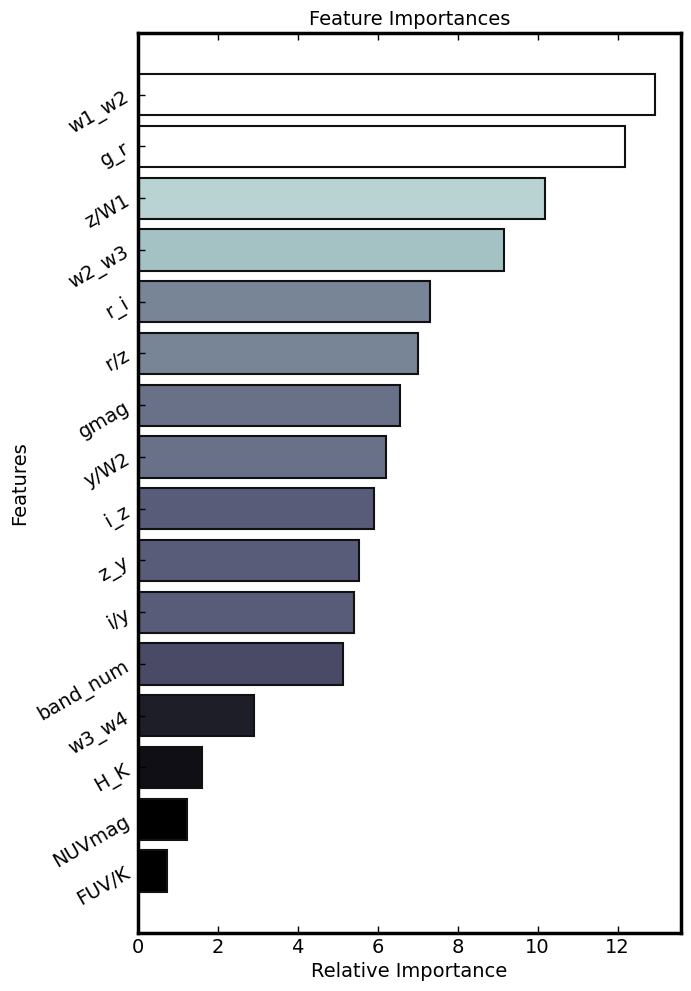

In [78]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_z_reg, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_regression_z_04.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [79]:
validation_prediction_reg = pyr.predict_model(final_z_reg, data=validation_df)

In [80]:
validation_prediction_reg.loc[:, ['Z', 'Label']].describe()

,Z,Label
count,1845.000000,1845.000000
mean,1.269937,1.249017
std,0.868773,0.770229
min,0.007000,0.040300
25%,0.500000,0.600900
50%,1.211000,1.203650
75%,1.892000,1.838400
max,4.734000,4.106400


In [81]:
# clb.vmax

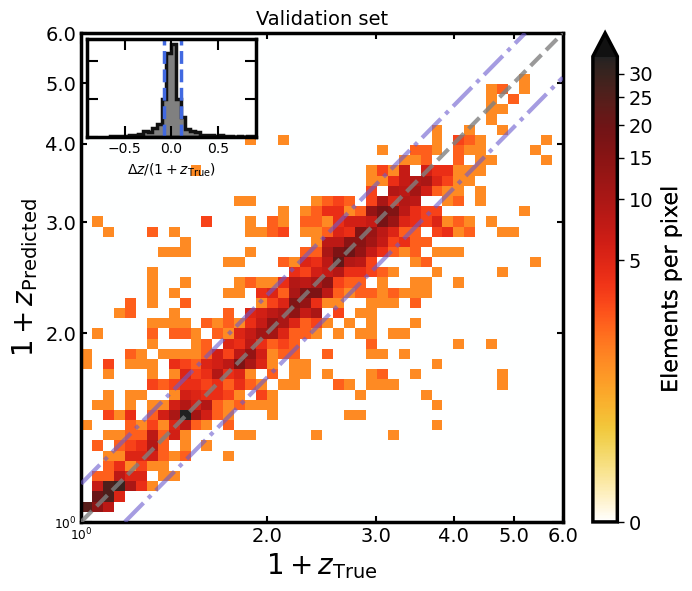

In [82]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')

# norm = ImageNormalize(vmin=0., vmax=5, stretch=LogStretch())
# norm = ImageNormalize(vmin=0., vmax=4)
vmax_dens = 331
# norm = ImageNormalize(vmin=0., stretch=LogStretch())
norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.3))

filt_pair_z   = np.isfinite(validation_prediction_reg.loc[:, 'Z']) & np.isfinite(validation_prediction_reg.loc[:, 'Label'])
max_for_range = np.nanmax([np.nanmax(1 + validation_prediction_reg.loc[filt_pair_z, 'Z']),\
                           np.nanmax(1 + validation_prediction_reg.loc[filt_pair_z, 'Label'])])

dens_1 = ax1.scatter_density((1 + validation_prediction_reg.loc[:, 'Z'].sample(frac=1, random_state=seed)),\
            (1 + validation_prediction_reg.loc[:, 'Label'].sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap('cet_linear_kryw_5_100_c64_r', vmax_dens), zorder=0, dpi=10, norm=norm, alpha=0.93)
ax1.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)


clb = plt.colorbar(dens_1, extend='max', norm=norm)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

######
axins = inset_axes(ax1, width='35%', height='20%', loc=2)
res_z_z = (validation_prediction_reg.loc[:, 'Label'] - validation_prediction_reg.loc[:, 'Z']) / (1 + validation_prediction_reg.loc[:, 'Z'])
axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)

axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')

axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
# axins.set_ylabel('Frequency', fontsize=20)
axins.tick_params(labelleft=False, labelbottom=True)
axins.tick_params(which='both', top=True, right=True, direction='in')
axins.tick_params(axis='both', which='major', labelsize=10)
axins.tick_params(which='major', length=8, width=1.5)
axins.tick_params(which='minor', length=4, width=1.5)
plt.setp(axins.spines.values(), linewidth=2.5)
plt.setp(axins.spines.values(), linewidth=2.5)
# ax1.grid(zorder=-10)
axins.set_xlim(left=-0.9, right=0.9)
# axins.figure.set_facecolor('b')
######


ax1.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
ax1.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=1., right=np.ceil(max_for_range))
ax1.set_ylim(bottom=1., top=np.ceil(max_for_range))
# ax1.grid(zorder=0)
# ax1.set_xlim(left=min_full_eddr, right=max_full_eddr)
# ax1.set_aspect('equal', 'box')
# ax1.set_aspect('auto', 'datalim')
ax1.set_title('Validation set', fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/compare_plot_validation_redshift_04.pdf', bbox_inches='tight')
plt.show()

In [83]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns  = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['Z']), train_test_df.loc[:, 'Z'], False, 'Z'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['Z']),
                train_test_df.loc[:, 'Z'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_df        = pd.concat([X_train, y_train], axis=1)
test_df         = pd.concat([X_test, y_test], axis=1)

In [84]:
train_prediction_reg      = pyr.predict_model(final_z_reg, data=train_df)
test_prediction_reg       = pyr.predict_model(final_z_reg, data=test_df)
train_test_prediction_reg = pyr.predict_model(final_z_reg, data=train_test_df)

In [85]:
sigma_mad_train    = sigma_mad(train_prediction_reg.loc[:, 'Z'],         train_prediction_reg.loc[:, 'Label'])
sigma_mad_test     = sigma_mad(test_prediction_reg.loc[:, 'Z'],          test_prediction_reg.loc[:, 'Label'])
sigma_mad_valid    = sigma_mad(validation_prediction_reg.loc[:, 'Z'],    validation_prediction_reg.loc[:, 'Label'])

In [86]:
sigma_nmad_train   = sigma_nmad(train_prediction_reg.loc[:, 'Z'],        train_prediction_reg.loc[:, 'Label'])
sigma_nmad_test    = sigma_nmad(test_prediction_reg.loc[:, 'Z'],         test_prediction_reg.loc[:, 'Label'])
sigma_nmad_valid   = sigma_nmad(validation_prediction_reg.loc[:, 'Z'],   validation_prediction_reg.loc[:, 'Label'])

In [87]:
sigma_z_train      = sigma_z(train_prediction_reg.loc[:, 'Z'],           train_prediction_reg.loc[:, 'Label'])
sigma_z_test       = sigma_z(test_prediction_reg.loc[:, 'Z'],            test_prediction_reg.loc[:, 'Label'])
sigma_z_valid      = sigma_z(validation_prediction_reg.loc[:, 'Z'],      validation_prediction_reg.loc[:, 'Label'])

In [88]:
sigma_z_norm_train = sigma_z_norm(train_prediction_reg.loc[:, 'Z'],      train_prediction_reg.loc[:, 'Label'])
sigma_z_norm_test  = sigma_z_norm(test_prediction_reg.loc[:, 'Z'],       test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_valid = sigma_z_norm(validation_prediction_reg.loc[:, 'Z'], validation_prediction_reg.loc[:, 'Label'])

In [89]:
out_frac_train     = outlier_frac(train_prediction_reg.loc[:, 'Z'],      train_prediction_reg.loc[:, 'Label'])
out_frac_test      = outlier_frac(test_prediction_reg.loc[:, 'Z'],       test_prediction_reg.loc[:, 'Label'])
out_frac_valid     = outlier_frac(validation_prediction_reg.loc[:, 'Z'], validation_prediction_reg.loc[:, 'Label'])

In [90]:
print('Scores for training set:')
print(f'Sigma MAD:\t\t{sigma_mad_train:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_train:.4f}')
print(f'Sigma z:\t\t{sigma_z_train:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_train:.4f}')
print(f'Out fraction:\t\t{out_frac_train:.4f}')
print('-' * 35)

Scores for training set:
Sigma MAD:		0.0862
Sigma NMAD:		0.0412
Sigma z:		0.2102
Sigma z norm:		0.0923
Out fraction:		0.0687
-----------------------------------


In [91]:
print('Scores for test set:')
print(f'Sigma MAD:\t\t{sigma_mad_test:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_test:.4f}')
print(f'Sigma z:\t\t{sigma_z_test:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_test:.4f}')
print(f'Out fraction:\t\t{out_frac_test:.4f}')
print('-' * 35)

Scores for test set:
Sigma MAD:		0.0841
Sigma NMAD:		0.0404
Sigma z:		0.2092
Sigma z norm:		0.0923
Out fraction:		0.0786
-----------------------------------


In [92]:
print('Scores for validation set:')
print(f'Sigma MAD:\t\t{sigma_mad_valid:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_valid:.4f}')
print(f'Sigma z:\t\t{sigma_z_valid:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_valid:.4f}')
print(f'Out fraction:\t\t{out_frac_valid:.4f}')
print('-' * 35)

Scores for validation set:
Sigma MAD:		0.1672
Sigma NMAD:		0.0764
Sigma z:		0.4358
Sigma z norm:		0.1976
Out fraction:		0.1908
-----------------------------------


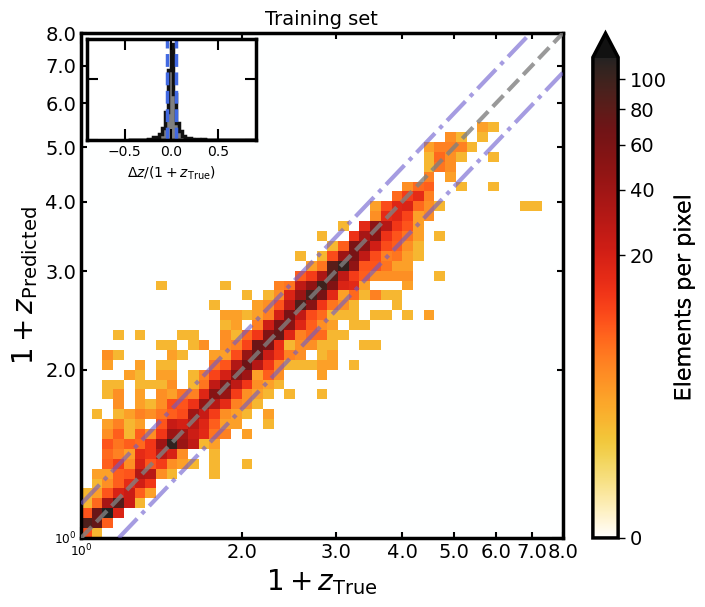

In [93]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')

# norm = ImageNormalize(vmin=0., vmax=5, stretch=LogStretch())
# norm = ImageNormalize(vmin=0., vmax=4)
vmax_dens = 947
# norm = ImageNormalize(vmin=0., stretch=LogStretch())
norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.3))

filt_pair_z = np.isfinite(train_prediction_reg.loc[:, 'Z']) & np.isfinite(train_prediction_reg.loc[:, 'Label'])
max_for_range = np.nanmax([np.nanmax(1 + train_prediction_reg.loc[filt_pair_z, 'Z']),\
                           np.nanmax(1 + train_prediction_reg.loc[filt_pair_z, 'Label'])])

dens_1 = ax1.scatter_density((1 + train_prediction_reg.loc[:, 'Z'].sample(frac=1, random_state=seed)),\
            (1 + train_prediction_reg.loc[:, 'Label'].sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap('cet_linear_kryw_5_100_c64_r', vmax_dens), zorder=0, dpi=10, norm=norm, alpha=0.93)
ax1.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)


clb = plt.colorbar(dens_1, extend='max', norm=norm)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

######
axins = inset_axes(ax1, width='35%', height='20%', loc=2)
res_z_z = (train_prediction_reg.loc[:, 'Label'] - train_prediction_reg.loc[:, 'Z']) / (1 + train_prediction_reg.loc[:, 'Z'])
axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)

axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')

axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
# axins.set_ylabel('Frequency', fontsize=20)
axins.tick_params(labelleft=False, labelbottom=True)
axins.tick_params(which='both', top=True, right=True, direction='in')
axins.tick_params(axis='both', which='major', labelsize=10)
axins.tick_params(which='major', length=8, width=1.5)
axins.tick_params(which='minor', length=4, width=1.5)
plt.setp(axins.spines.values(), linewidth=2.5)
plt.setp(axins.spines.values(), linewidth=2.5)
# ax1.grid(zorder=-10)
axins.set_xlim(left=-0.9, right=0.9)
# axins.figure.set_facecolor('b')
######


ax1.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
ax1.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=1., right=np.ceil(max_for_range))
ax1.set_ylim(bottom=1., top=np.ceil(max_for_range))
# ax1.grid(zorder=0)
# ax1.set_xlim(left=min_full_eddr, right=max_full_eddr)
# ax1.set_aspect('equal', 'box')
# ax1.set_aspect('auto', 'datalim')
fig.tight_layout()
ax1.set_title('Training set', fontsize=14)
if save_plot_flag:
    plt.savefig('plots/compare_plot_train_redshift_04.pdf', bbox_inches='tight')
plt.show()

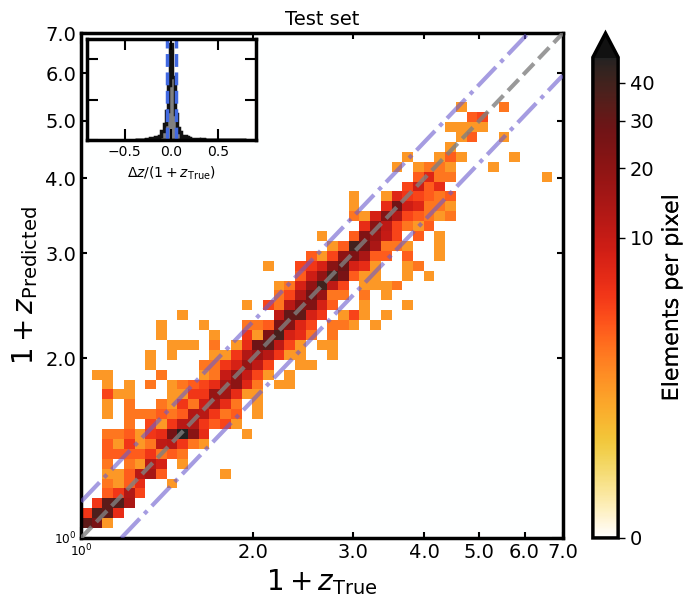

In [94]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')

# norm = ImageNormalize(vmin=0., vmax=5, stretch=LogStretch())
# norm = ImageNormalize(vmin=0., vmax=4)
vmax_dens = 388
# norm = ImageNormalize(vmin=0., stretch=LogStretch())
norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.3))

filt_pair_z = np.isfinite(test_prediction_reg.loc[:, 'Z']) & np.isfinite(test_prediction_reg.loc[:, 'Label'])
max_for_range = np.nanmax([np.nanmax(1 + test_prediction_reg.loc[filt_pair_z, 'Z']),\
                           np.nanmax(1 + test_prediction_reg.loc[filt_pair_z, 'Label'])])

dens_1 = ax1.scatter_density((1 + test_prediction_reg.loc[:, 'Z'].sample(frac=1, random_state=seed)),\
            (1 + test_prediction_reg.loc[:, 'Label'].sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap('cet_linear_kryw_5_100_c64_r', vmax_dens), zorder=0, dpi=10, norm=norm, alpha=0.93)
ax1.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
ax1.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)


clb = plt.colorbar(dens_1, extend='max', norm=norm)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

######
axins = inset_axes(ax1, width='35%', height='20%', loc=2)
res_z_z = (test_prediction_reg.loc[:, 'Label'] - test_prediction_reg.loc[:, 'Z']) / (1 + test_prediction_reg.loc[:, 'Z'])
axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)

axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')

axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
# axins.set_ylabel('Frequency', fontsize=20)
axins.tick_params(labelleft=False, labelbottom=True)
axins.tick_params(which='both', top=True, right=True, direction='in')
axins.tick_params(axis='both', which='major', labelsize=10)
axins.tick_params(which='major', length=8, width=1.5)
axins.tick_params(which='minor', length=4, width=1.5)
plt.setp(axins.spines.values(), linewidth=2.5)
plt.setp(axins.spines.values(), linewidth=2.5)
# ax1.grid(zorder=-10)
axins.set_xlim(left=-0.9, right=0.9)
# axins.figure.set_facecolor('b')
######


ax1.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
ax1.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=1., right=np.ceil(max_for_range))
ax1.set_ylim(bottom=1., top=np.ceil(max_for_range))
# ax1.grid(zorder=0)
# ax1.set_xlim(left=min_full_eddr, right=max_full_eddr)
# ax1.set_aspect('equal', 'box')
# ax1.set_aspect('auto', 'datalim')
fig.tight_layout()
ax1.set_title('Test set', fontsize=14)
if save_plot_flag:
    plt.savefig('plots/compare_plot_test_redshift_04.pdf', bbox_inches='tight')
plt.show()

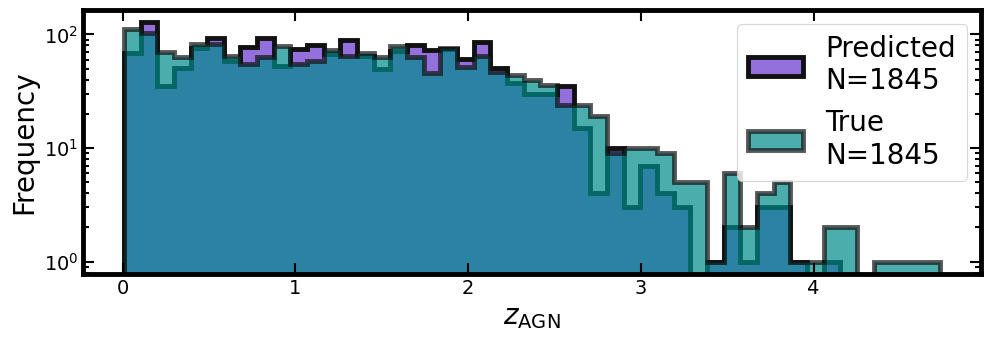

In [95]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(validation_prediction_reg.loc[:, 'Z']),\
                           np.nanmin(validation_prediction_reg.loc[:, 'Label'])])
max_for_range = np.nanmax([np.nanmax(validation_prediction_reg.loc[:, 'Z']),\
                           np.nanmax(validation_prediction_reg.loc[:, 'Label'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)

_, bins, _ = ax1.hist(validation_prediction_reg.loc[:, 'Label'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"Predicted\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Label'] > 0))}")
ax1.hist(validation_prediction_reg.loc[:, 'Z'], bins=bins_z, histtype='stepfilled', ec='k', fc='darkcyan',\
         lw=3.5, label=f"True\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Z'] > 0))}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$z_{\mathrm{AGN}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=20)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/hist_true_predicted_z_04.pdf')
plt.show()

---

#### Redshift threshold

In order to understand where (in redshift) the predictions are far off from real values, we can use the evolution of the outlier fraction to obtain the point where that happens.

In [96]:
n_elems        = 50
z_range_lin    = np.linspace(0, np.nanmax(train_test_prediction_reg.loc[:, 'Z']), n_elems)
z_range_log    = np.logspace(np.log10(np.abs(np.nanmin(train_test_prediction_reg.loc[:, 'Z']))),\
                          np.log10(np.abs(np.nanmax(train_test_prediction_reg.loc[:, 'Z']))), n_elems)
z_range_lg_inv = np.abs(np.abs(np.nanmax(train_test_prediction_reg.loc[:, 'Z']))) - z_range_log

In [97]:
train_test_prediction_reg = train_test_prediction_reg.rename(columns={'Label': 'pred_Z'})

In [98]:
s_MAD_z_z_lin          = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lin, sigma_mad,      'Z',            'pred_Z')
s_NMAD_z_z_lin         = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lin, sigma_nmad,     'Z',            'pred_Z')
sigma_z_z_z_lin        = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lin, sigma_z,        'Z',            'pred_Z')
sigma_z_N_z_z_lin      = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lin, sigma_z_norm,   'Z',            'pred_Z')
out_fr_z_z_lin         = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lin, outlier_frac,   'Z',            'pred_Z')

In [99]:
s_MAD_z_z_log          = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_log, sigma_mad,      'Z',            'pred_Z')
s_NMAD_z_z_log         = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_log, sigma_nmad,     'Z',            'pred_Z')
sigma_z_z_z_log        = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_log, sigma_z,        'Z',            'pred_Z')
sigma_z_N_z_z_log      = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_log, sigma_z_norm,   'Z',            'pred_Z')
out_fr_z_z_log         = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_log, outlier_frac,   'Z',            'pred_Z')

In [100]:
s_MAD_z_z_log_inv      = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lg_inv, sigma_mad,      'Z',            'pred_Z')
s_NMAD_z_z_log_inv     = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lg_inv, sigma_nmad,     'Z',            'pred_Z')
sigma_z_z_z_log_inv    = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lg_inv, sigma_z,        'Z',            'pred_Z')
sigma_z_N_z_z_log_inv  = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lg_inv, sigma_z_norm,   'Z',            'pred_Z')
out_fr_z_z_log_inv     = z_metric_in_z_ranges(train_test_prediction_reg, 'Z', z_range_lg_inv, outlier_frac,   'Z',            'pred_Z')

In [101]:
pd.DataFrame(data=np.array([z_range_lin, out_fr_z_z_lin]).T, columns=['z', 'Recall'])

,z,Recall
0,0.000000,0.071680
1,0.126735,0.070261
2,0.253469,0.062954
3,0.380204,0.058590
4,0.506939,0.054979
5,0.633673,0.056044
6,0.760408,0.056344
7,0.887143,0.056583
8,1.013878,0.055869
9,1.140612,0.058027


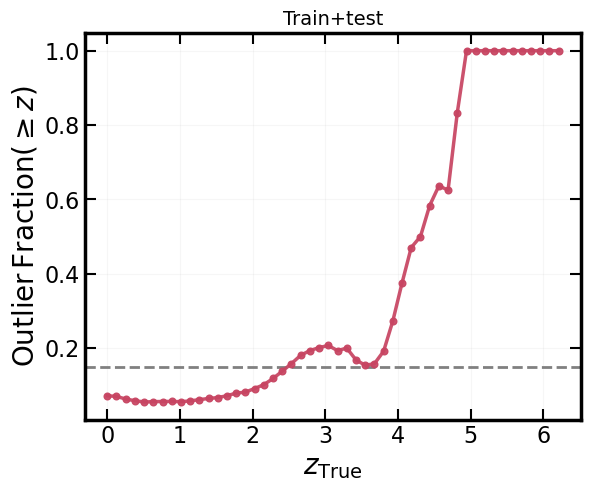

In [102]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, out_fr_z_z_lin, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/outlier_fraction_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

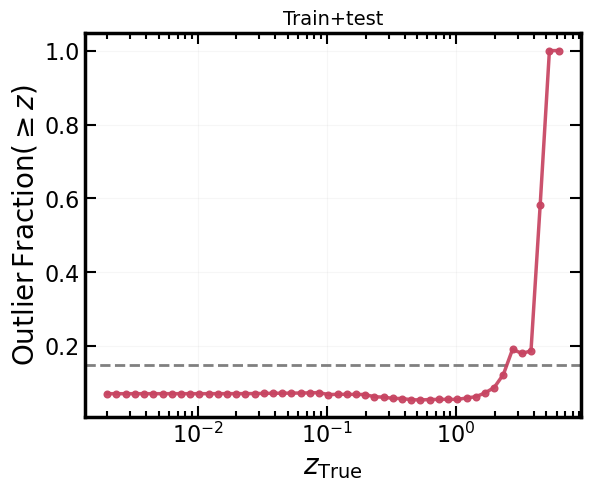

In [103]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='log', yscale='linear')
plot_metric_over_z(z_range_log, out_fr_z_z_log, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/outlier_fraction_log_redshift_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

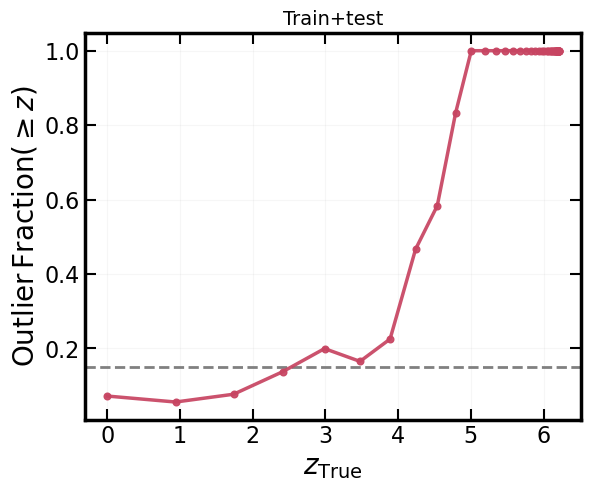

In [104]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lg_inv, out_fr_z_z_log_inv, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/outlier_fraction_inv_log_redshift_redshift_train_test.pdf', bbox_inches='tight')
plt.show()